In [4133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import re
import datetime
from datetime import datetime
from numpy.random import seed 
from numpy.random import randn 
from numpy import mean
from numpy import std
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


from numpy import percentile

import scipy as sc
from pandas import read_csv


from sklearn.preprocessing import PowerTransformer

In [4134]:
df_other_train = read_csv("data/other_train.csv")
df_personal_train = read_csv("data/personal_train.csv")
df_other_valid = read_csv("data/other_valid.csv")
df_personal_valid = read_csv("data/personal_valid.csv")

df_merged1 = pd.merge(df_personal_train, df_other_train, on=['name', 'address'])
df_merged2 = pd.merge(df_other_valid, df_personal_valid, on=['name', 'address'])

df_merged1 = df_merged1.drop('Unnamed: 0_x', 1)
df_merged1 = df_merged1.drop('Unnamed: 0_y', 1)

df_merged1

,name,address,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,...,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",58,Male,1961-04-27,White,Married-civ-spouse,Transport-moving,FALSE,11.0,...,0.0,Assoc-voc,241259.0,0.0,<=50K,"{'mean_glucose':'132.9296875','std_glucose':'6...",United-States,40.0,0.0,Private
1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",43,Female,1976-09-12,Black,Divorced,Other-service,f,9.0,...,0.0,HS-grad,172232.0,0.0,<=50K,"{'mean_glucose':'103.1171875','std_glucose':'-...",United-States,30.0,0.0,Private
2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",51,Male,1967-11-12,White,Married-civ-spouse,Exec-managerial,f,10.0,...,0.0,Some-college,345705.0,0.0,<=50K,"{'mean_glucose':'125.5390625','std_glucose':'5...",United-States,40.0,0.0,Private
3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",66,Male,1953-06-02,Amer-Indian-Eskimo,Never-married,Handlers-cleaners,f,9.0,...,0.0,HS-grad,149297.0,0.0,<=50K,"{'mean_glucose':'136.0859375','std_glucose':'4...",United-States,30.0,0.0,Private
4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",45,Female,1974/09/11,White,Never-married,Craft-repair,f,10.0,...,0.0,Some-college,253262.0,0.0,<=50K,"{'mean_glucose':'99.328125','std_glucose':'38....",United-States,40.0,0.0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,Clair Pinkleton,"8582 Lee Roads\r\nCostaburgh, SC 21897",53,Female,1966-04-29,White,Never-married,Adm-clerical,f,13.0,...,0.0,Bachelors,368739.0,0.0,<=50K,"{'mean_glucose':'161.4453125','std_glucose':'n...",United-States,40.0,0.0,Private
3979,William Pope,68430 Erik Terrace Suite 279\r\nPort Adamborou...,81,Male,1938-10-24 00:00:00,White,Never-married,Other-service,f,9.0,...,0.0,HS-grad,387430.0,1.0,<=50K,"{'mean_glucose':'114.1484375','std_glucose':'5...",United-States,18.0,0.0,private
3980,Jared Kinsey,Unit 8416 Box 3801\r\nDPO AE 31166,46,Female,1973-02-23,Black,Divorced,Adm-clerical,f,13.0,...,0.0,Bachelors,137304.0,0.0,<=50K,"{'mean_glucose':'128.734375','std_glucose':'57...",United-States,40.0,0.0,Private
3981,Frederick Lawley,"34420 Brian Stream\r\nLake Michaeltown, MS 01832",46,Female,1973-08-09 00:00:00,White,Never-married,Other-service,f,6.0,...,0.0,10th,65225.0,1.0,<=50K,"{'mean_glucose':'70.7421875','std_glucose':'44...",United-States,40.0,0.0,Private


In [4135]:
df_merged1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            3983 non-null   object 
 1   address         3983 non-null   object 
 2   age             3983 non-null   int64  
 3   sex             3983 non-null   object 
 4   date_of_birth   3983 non-null   object 
 5   race            3691 non-null   object 
 6   marital-status  3970 non-null   object 
 7   occupation      3961 non-null   object 
 8   pregnant        3969 non-null   object 
 9   education-num   3961 non-null   float64
 10  relationship    3954 non-null   object 
 11  capital-gain    3969 non-null   float64
 12  education       3972 non-null   object 
 13  fnlwgt          3968 non-null   float64
 14  class           3960 non-null   float64
 15  income          3972 non-null   object 
 16  medical_info    3966 non-null   object 
 17  native-country  3966 non-null   o

In [4136]:
# def replace_value(data_frame):
#     aggregation_functions = {'name': 'first', 'address': 'first', 'race': 'first', 'marital-status': 'first', 'occupation': 'first',
#                              'pregnant': 'first', 'education-num': 'first', 'relationship': 'first', 'capital-gain': 'first',
#                              'education': 'first', 'fnlwgt': 'first', 'class': 'first', 'income': 'first', 'medical_info': 'first',
#                             'native-country': 'first', 'hours-per-week': 'first', 'capital-loss': 'first', 'workclass': 'first'}
#     return data_frame.groupby(data_frame['name'], as_index=False).aggregate(aggregation_functions)

def unify_rows(data_frame):
    aggregation_functions = {}
    for col in data_frame.columns:
        aggregation_functions[col] = "first" 

    return data_frame.groupby(data_frame['name'], as_index=False).aggregate(aggregation_functions)


In [4137]:
df_merged1 = unify_rows(df_merged1)

In [4138]:
df_merged1.shape[0]

3933

In [4139]:
df_merged = df_merged1.merge(df_merged2, how='outer')

df_merged = df_merged.rename(columns={'Unnamed: 0_x': 'index',})
df_merged = df_merged.drop('Unnamed: 0_y', 1)
df_merged = df_merged.drop('index', 1)
df_merged

,name,address,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,...,capital-gain,education,fnlwgt,class,income,medical_info,native-country,hours-per-week,capital-loss,workclass
0,Aaron Davis,"379 Rodriguez Inlet\r\nFisherbury, MD 83114",37,Female,1982/02/08,White,Divorced,Other-service,f,9.0,...,0.0,HS-grad,203463.0,0.0,<=50K,"{'mean_glucose':'130.640625','std_glucose':'na...",United-States,40.0,0.0,Private
1,Aaron Dini,"105 Medina Springs Suite 462\r\nEmilyland, KS ...",58,Female,1961-05-04,White,Never-married,Other-service,f,9.0,...,0.0,HS-grad,166744.0,0.0,<=50K,"{'mean_glucose':'99.828125','std_glucose':'47....",United-States,38.0,0.0,Private
2,Aaron Gann,59685 Thomas Extension Apt. 142\r\nFieldsborou...,48,Male,1971-02-03 00 00 00,White,Married-civ-spouse,Handlers-cleaners,f,10.0,...,0.0,Some-college,165517.0,0.0,<=50K,"{'mean_glucose':'92.7734375','std_glucose':'34...",United-States,40.0,0.0,Private
3,Aaron Gregg,"10883 Williams Locks Suite 821\r\nEast Carmen,...",45,Male,1973-12-23,White,Married-civ-spouse,Farming-fishing,f,4.0,...,0.0,7th-8th,22907.0,0.0,<=50K,"{'mean_glucose':'101.6953125','std_glucose':'4...",United-States,40.0,0.0,Self-emp-not-inc
4,Aaron Lindley,"564 Stevenson Park Apt. 839\r\nRodriguezville,...",56,Male,1963-08-22,White,Divorced,Transport-moving,f,10.0,...,0.0,Some-college,88019.0,0.0,<=50K,"{'mean_glucose':'114.8359375','std_glucose':'5...",United-States,55.0,0.0,Private
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,Arturo Mckee,"64582 Mcgee Orchard\r\nBridgeschester, VT 81156",60,Male,1959-09-21,White,Married-civ-spouse,Prof-specialty,f,15.0,...,0.0,Prof-school,132601.0,1.0,>50K,"{'mean_glucose':'28.1953125','std_glucose':'39...",United-States,40.0,0.0,Private
5290,Bennie Jones,"9406 Desiree Rest\r\nSouth Laurafort, ME 72779",43,Male,76-09-04,White,Married-civ-spouse,Transport-moving,FALSE,9.0,...,0.0,HS-grad,85434.0,0.0,<=50K,"{'mean_glucose':'110.0546875','std_glucose':'4...",United-States,40.0,0.0,Private
5291,Bobby Hawk,"41416 Ellis Island\r\nEdgarchester, OR 73214",50,Male,1968-12-02,White,Married-civ-spouse,Prof-specialty,f,13.0,...,5178.0,Bachelors,174575.0,0.0,>50K,"{'mean_glucose':'159.078125','std_glucose':'39...",United-States,40.0,0.0,Local-gov
5292,Wally Suggs,"624 Jeremiah Inlet Suite 082\r\nEast Jerome, H...",49,Female,1970-04-05,White,Divorced,Sales,f,9.0,...,0.0,HS-grad,148903.0,0.0,<=50K,"{'mean_glucose':'116.46875','std_glucose':'35....",United-States,40.0,0.0,private


In [4140]:
# dir_in = 'data'
# filenames = [i for i in glob.glob(dir_in + '/*')]
# print(*filenames, sep='\n')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5294 non-null   object 
 1   address         5294 non-null   object 
 2   age             5294 non-null   int64  
 3   sex             5294 non-null   object 
 4   date_of_birth   5294 non-null   object 
 5   race            4912 non-null   object 
 6   marital-status  5280 non-null   object 
 7   occupation      5276 non-null   object 
 8   pregnant        5275 non-null   object 
 9   education-num   5275 non-null   float64
 10  relationship    5271 non-null   object 
 11  capital-gain    5274 non-null   float64
 12  education       5278 non-null   object 
 13  fnlwgt          5282 non-null   float64
 14  class           5278 non-null   float64
 15  income          5273 non-null   object 
 16  medical_info    5279 non-null   object 
 17  native-country  5281 non-null   o

In [4141]:
medical_line = df_merged["medical_info"].str.replace(':', ',').str.replace("'", '').str.replace("{", '').str.replace("}", '')
medical_elements = medical_line.str.split(",", -1, expand = True)

diabetes_dataset = {}

for index in range(0, medical_elements.shape[1]):
    i = medical_elements[0][0]
    if(index % 2 == 0):
        diabetes_dataset[medical_elements[index][0]] = medical_elements[index + 1]
        
diabetes_dataset = pd.DataFrame(diabetes_dataset)
df_merged = pd.concat([df_merged, diabetes_dataset.reindex(df_merged.index)], axis = 1)
df_merged = df_merged.drop(columns = ['medical_info'])

In [4142]:
df_merged['mean_glucose'] = df_merged['mean_glucose'].astype(float)
df_merged['std_glucose'] = df_merged['std_glucose'].astype(float)
df_merged['kurtosis_glucose'] = df_merged['kurtosis_glucose'].astype(float)
df_merged['skewness_glucose'] = df_merged['skewness_glucose'].astype(float)
df_merged['mean_oxygen'] = df_merged['mean_oxygen'].astype(float)
df_merged['std_oxygen'] = df_merged['std_oxygen'].astype(float)
df_merged['kurtosis_oxygen'] = df_merged['kurtosis_oxygen'].astype(float)
df_merged['skewness_oxygen'] = df_merged['skewness_oxygen'].astype(float)

In [4143]:
# df_merged.set_index('index', inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5275 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4144]:
df_merged['pregnant'].unique()

array(['f', 'FALSE', 'F', 't', 'TRUE', 'T', nan], dtype=object)

In [4145]:
def cleanse_some_values(data_frame, column, change_from, change_to):
    for i in range(len(change_from)):
        data_frame.loc[data_frame[column] == change_from[i], column] = change_to

In [4146]:
def unify_values(data_frame):
    unify_ppl = Pipeline([
                    ('1. step',  cleanse_some_values(data_frame, 'pregnant', ["F", "FALSE"], "f")),
                    ('2. step', cleanse_some_values(data_frame, 'pregnant', ["T", "TRUE"], "t")),

                    ('3. step', cleanse_some_values(data_frame, 'marital-status', [" Widowed", " Never-married", " Divorced"], "single")),
                    ('4. step',cleanse_some_values(data_frame, 'marital-status', [" Married-civ-spouse", " Separated", " Married-AF-spouse", " Married-spouse-absent"], "married")),

                    ('5. step', cleanse_some_values(data_frame, 'education', [" 1st-4th", " 5th-6th", " 7th-8th", " 9th", " 10th", " 11th", " 12th"], "Primary school")),
                    ('6. step', cleanse_some_values(data_frame, 'education', [" Bachelors", " Masters", " Doctorate"], "College")),
                    ('7. step', cleanse_some_values(data_frame, 'education', [" Assoc-voc", " HS-grad", " Prof-school", " Assoc-acdm", " Some-college"], "Highschool")),
                    ('8. step', cleanse_some_values(data_frame, 'education', [" Preschool"], "Preschool")),

                    ('9. step', cleanse_some_values(data_frame, 'workclass', [" Private"], "private")),
                    ('10. step', cleanse_some_values(data_frame, 'workclass', [" Self-emp-not-inc", " Self-emp-inc", "self-emp-inc", "self-emp-not-inc"], "self-emp")),
                    ('11. step', cleanse_some_values(data_frame, 'workclass', [" Never-worked", " Without-pay"], "not-working")),
                    ('12. step', cleanse_some_values(data_frame, 'workclass', [" Local-gov", "local-gov", " State-gov", "state-gov", " Federal-gov", "federal-gov"], "government")),
                    ('13. step', cleanse_some_values(data_frame, 'workclass', [" ?", "?"], np.nan))
                    ])
    unify_ppl = unify_ppl.fit(data_frame)
    data_frame = unify_ppl.transform(data_frame)
    return data_frame

In [4147]:
df_merged = unify_values(df_merged)

In [4148]:
df_merged

,name,address,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,...,capital-loss,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Aaron Davis,"379 Rodriguez Inlet\r\nFisherbury, MD 83114",37,Female,1982/02/08,White,single,Other-service,f,9.0,...,0.0,private,130.640625,NaN,-0.278638,-0.200794,11.642977,41.904978,3.602677,11.954904
1,Aaron Dini,"105 Medina Springs Suite 462\r\nEmilyland, KS ...",58,Female,1961-05-04,White,single,Other-service,f,9.0,...,0.0,private,99.828125,47.239766,0.469564,0.767540,2.816054,16.659173,7.999821,78.263172
2,Aaron Gann,59685 Thomas Extension Apt. 142\r\nFieldsborou...,48,Male,1971-02-03 00 00 00,White,married,Handlers-cleaners,f,10.0,...,0.0,private,92.773438,34.005793,0.602241,3.485345,1.086957,12.610281,14.133424,224.144386
3,Aaron Gregg,"10883 Williams Locks Suite 821\r\nEast Carmen,...",45,Male,1973-12-23,White,married,Farming-fishing,f,4.0,...,0.0,self-emp,101.695312,47.525414,0.402180,0.239359,2.717391,19.675471,8.112776,71.312964
4,Aaron Lindley,"564 Stevenson Park Apt. 839\r\nRodriguezville,...",56,Male,1963-08-22,White,single,Transport-moving,f,10.0,...,0.0,private,114.835938,51.926146,-0.009627,-0.528806,1.227425,12.031249,14.087309,234.473686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,Arturo Mckee,"64582 Mcgee Orchard\r\nBridgeschester, VT 81156",60,Male,1959-09-21,White,married,Prof-specialty,f,15.0,...,0.0,private,28.195312,3921.376883,4.269629,18.154262,103.806020,85.647206,0.095444,-1.358248
5290,Bennie Jones,"9406 Desiree Rest\r\nSouth Laurafort, ME 72779",43,Male,76-09-04,White,married,Transport-moving,f,9.0,...,0.0,private,110.054688,45.564053,0.379363,0.133880,1.261706,13.032154,13.294267,202.930061
5291,Bobby Hawk,"41416 Ellis Island\r\nEdgarchester, OR 73214",50,Male,1968-12-02,White,married,Prof-specialty,f,13.0,...,0.0,government,159.078125,39.412405,-0.363835,1.141354,0.795987,9.677674,18.652776,427.256817
5292,Wally Suggs,"624 Jeremiah Inlet Suite 082\r\nEast Jerome, H...",49,Female,1970-04-05,White,single,Sales,f,9.0,...,0.0,private,116.468750,35.632222,0.386352,2.199301,1.541806,14.173109,12.022914,164.296414


In [4149]:
# cleanse_some_values(df_merged, 'pregnant', ["F", "FALSE"], "f")
# cleanse_some_values(df_merged, 'pregnant', ["T", "TRUE"], "t")

In [4150]:
df_merged['marital-status'].unique()

array(['single', 'married', nan], dtype=object)

In [4151]:
# cleanse_some_values(df_merged, 'marital-status', [" Widowed", " Never-married", " Divorced"], "single")
# cleanse_some_values(df_merged, 'marital-status', [" Married-civ-spouse", " Separated", " Married-AF-spouse", " Married-spouse-absent"], "married")

In [4152]:
df_merged

,name,address,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,...,capital-loss,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Aaron Davis,"379 Rodriguez Inlet\r\nFisherbury, MD 83114",37,Female,1982/02/08,White,single,Other-service,f,9.0,...,0.0,private,130.640625,NaN,-0.278638,-0.200794,11.642977,41.904978,3.602677,11.954904
1,Aaron Dini,"105 Medina Springs Suite 462\r\nEmilyland, KS ...",58,Female,1961-05-04,White,single,Other-service,f,9.0,...,0.0,private,99.828125,47.239766,0.469564,0.767540,2.816054,16.659173,7.999821,78.263172
2,Aaron Gann,59685 Thomas Extension Apt. 142\r\nFieldsborou...,48,Male,1971-02-03 00 00 00,White,married,Handlers-cleaners,f,10.0,...,0.0,private,92.773438,34.005793,0.602241,3.485345,1.086957,12.610281,14.133424,224.144386
3,Aaron Gregg,"10883 Williams Locks Suite 821\r\nEast Carmen,...",45,Male,1973-12-23,White,married,Farming-fishing,f,4.0,...,0.0,self-emp,101.695312,47.525414,0.402180,0.239359,2.717391,19.675471,8.112776,71.312964
4,Aaron Lindley,"564 Stevenson Park Apt. 839\r\nRodriguezville,...",56,Male,1963-08-22,White,single,Transport-moving,f,10.0,...,0.0,private,114.835938,51.926146,-0.009627,-0.528806,1.227425,12.031249,14.087309,234.473686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,Arturo Mckee,"64582 Mcgee Orchard\r\nBridgeschester, VT 81156",60,Male,1959-09-21,White,married,Prof-specialty,f,15.0,...,0.0,private,28.195312,3921.376883,4.269629,18.154262,103.806020,85.647206,0.095444,-1.358248
5290,Bennie Jones,"9406 Desiree Rest\r\nSouth Laurafort, ME 72779",43,Male,76-09-04,White,married,Transport-moving,f,9.0,...,0.0,private,110.054688,45.564053,0.379363,0.133880,1.261706,13.032154,13.294267,202.930061
5291,Bobby Hawk,"41416 Ellis Island\r\nEdgarchester, OR 73214",50,Male,1968-12-02,White,married,Prof-specialty,f,13.0,...,0.0,government,159.078125,39.412405,-0.363835,1.141354,0.795987,9.677674,18.652776,427.256817
5292,Wally Suggs,"624 Jeremiah Inlet Suite 082\r\nEast Jerome, H...",49,Female,1970-04-05,White,single,Sales,f,9.0,...,0.0,private,116.468750,35.632222,0.386352,2.199301,1.541806,14.173109,12.022914,164.296414


In [4153]:
df_merged['education'].unique()

array(['Highschool', 'Primary school', 'College', 'Preschool', nan],
      dtype=object)

In [4154]:
# cleanse_some_values(df_merged, 'education', [" 1st-4th", " 5th-6th", " 7th-8th", " 9th", " 10th", " 11th", " 12th"], "Primary school")
# cleanse_some_values(df_merged, 'education', [" Bachelors", " Masters", " Doctorate"], "College")
# cleanse_some_values(df_merged, 'education', [" Assoc-voc", " HS-grad", " Prof-school", " Assoc-acdm", " Some-college"], "Highschool")
# df_merged.loc[df_merged['education'] == " Preschool", 'education'] = "Preschool"

In [4155]:
df_merged['workclass'].unique()

array(['private', 'self-emp', nan, 'government', 'not-working'],
      dtype=object)

In [4156]:
# cleanse_some_values(df_merged, 'workclass', [" Private"], "private")
# cleanse_some_values(df_merged, 'workclass', [" Self-emp-not-inc", " Self-emp-inc", "self-emp-inc", "self-emp-not-inc"], "self-emp")
# cleanse_some_values(df_merged, 'workclass', [" Never-worked", " Without-pay"], "not-working")
# cleanse_some_values(df_merged, 'workclass', [" Local-gov", "local-gov", " State-gov", "state-gov", " Federal-gov", "federal-gov"], "government")
# cleanse_some_values(df_merged, 'workclass', [" ?", "?"], np.nan)

In [4157]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5275 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4158]:
# def change_date_format(data_frame, column):
#     for i in range(len(data_frame[column])):
#         date_format = data_frame[column][i].replace('/', '-')
#         data_frame.loc[i, column] = date_format[:10]
#     return data_frame

def change_date_format(data_frame, column):
    for i in range(len(data_frame[column])):
        date_format = str(data_frame[column][i])
        date_format = date_format.replace('/', '-')
        if date_format[2] == '-' and len(date_format) < 10:
            temp_year = int(date_format[:2])
            if(temp_year <= 20):
                if(temp_year < 10):
                    year = '200'+str(temp_year)
                else:
                    year = '20'+str(temp_year)
            else:
                year = '19'+str(temp_year)
            data_frame.loc[i, column] = year+date_format[2:10]
        elif date_format[2] == '-' and len(date_format) == 10:
            day = date_format[:2]
            month = date_format[3:5]
            year = date_format[6:10]
            data_frame.loc[i, column] = year+'-'+month+'-'+day
        else:
            data_frame.loc[i, column] = date_format[:10]
    return data_frame

In [4159]:
df_merged = change_date_format(df_merged,'date_of_birth')

In [4160]:
date_formats = df_merged.date_of_birth
date_formats = date_formats.str.replace('\d', '0')
date_formats.unique()

array(['0000-00-00'], dtype=object)

In [4161]:
df_merged['date_of_birth']

0       1982-02-08
1       1961-05-04
2       1971-02-03
3       1973-12-23
4       1963-08-22
           ...    
5289    1959-09-21
5290    1976-09-04
5291    1968-12-02
5292    1970-04-05
5293    1944-03-24
Name: date_of_birth, Length: 5294, dtype: object

In [4162]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5275 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4163]:
# def calculate_age(data_frame, date_of_birth, age):
#     for i in range(len(data_frame[date_of_birth])):
# #         test = data_frame[age][i]
# #         itest = int(test)
# #         if test < 1 or test > 80:
# #             print(test)

# #         year = re.sub(r'[^0-9]', '', data_frame[date_of_birth][i])
#         year = data_frame[date_of_birth][i]
#         year = year[:4]            
#         new_age = 2020 - int(year)
        
# #         itest = int(new_age)
# #         if itest < 1 or itest > 80:
# #             print(itest)
        
#         data_frame.loc[i, age] = str(new_age)
#     return data_frame

In [4164]:
# df_merged = age_from_year(df_merged, 'date_of_birth', 'age')
# # calculate_age(df_merged, 'date_of_birth', 'age')

In [4165]:
df_merged

,name,address,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,...,capital-loss,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,Aaron Davis,"379 Rodriguez Inlet\r\nFisherbury, MD 83114",37,Female,1982-02-08,White,single,Other-service,f,9.0,...,0.0,private,130.640625,NaN,-0.278638,-0.200794,11.642977,41.904978,3.602677,11.954904
1,Aaron Dini,"105 Medina Springs Suite 462\r\nEmilyland, KS ...",58,Female,1961-05-04,White,single,Other-service,f,9.0,...,0.0,private,99.828125,47.239766,0.469564,0.767540,2.816054,16.659173,7.999821,78.263172
2,Aaron Gann,59685 Thomas Extension Apt. 142\r\nFieldsborou...,48,Male,1971-02-03,White,married,Handlers-cleaners,f,10.0,...,0.0,private,92.773438,34.005793,0.602241,3.485345,1.086957,12.610281,14.133424,224.144386
3,Aaron Gregg,"10883 Williams Locks Suite 821\r\nEast Carmen,...",45,Male,1973-12-23,White,married,Farming-fishing,f,4.0,...,0.0,self-emp,101.695312,47.525414,0.402180,0.239359,2.717391,19.675471,8.112776,71.312964
4,Aaron Lindley,"564 Stevenson Park Apt. 839\r\nRodriguezville,...",56,Male,1963-08-22,White,single,Transport-moving,f,10.0,...,0.0,private,114.835938,51.926146,-0.009627,-0.528806,1.227425,12.031249,14.087309,234.473686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5289,Arturo Mckee,"64582 Mcgee Orchard\r\nBridgeschester, VT 81156",60,Male,1959-09-21,White,married,Prof-specialty,f,15.0,...,0.0,private,28.195312,3921.376883,4.269629,18.154262,103.806020,85.647206,0.095444,-1.358248
5290,Bennie Jones,"9406 Desiree Rest\r\nSouth Laurafort, ME 72779",43,Male,1976-09-04,White,married,Transport-moving,f,9.0,...,0.0,private,110.054688,45.564053,0.379363,0.133880,1.261706,13.032154,13.294267,202.930061
5291,Bobby Hawk,"41416 Ellis Island\r\nEdgarchester, OR 73214",50,Male,1968-12-02,White,married,Prof-specialty,f,13.0,...,0.0,government,159.078125,39.412405,-0.363835,1.141354,0.795987,9.677674,18.652776,427.256817
5292,Wally Suggs,"624 Jeremiah Inlet Suite 082\r\nEast Jerome, H...",49,Female,1970-04-05,White,single,Sales,f,9.0,...,0.0,private,116.468750,35.632222,0.386352,2.199301,1.541806,14.173109,12.022914,164.296414


In [4166]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5275 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4167]:
# def remove_outliers(data_frame, column):
#     a = data_frame[column]
#     lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
#     upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
#     outliers = a[(a > upper) | (a < lower)]
#     data_frame = data_frame.drop(outliers.index)
#     return data_frame

In [4168]:
# df_merged = remove_outliers(df_merged, 'age')

In [4169]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5275 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4170]:
column = df_merged["age"]
max_value = column.max()
print(max_value)

113


Odstránenie outliers v atribúte age

In [4171]:
def man_not_pregnant(data_frame, sex, pregnant):
    for i in range(len(data_frame[sex])):
        if(data_frame[sex][i] == " Male") and data_frame[pregnant][i] != "f":
            data_frame.loc[i, pregnant] = "f"
    return data_frame

In [4172]:
data_frame = man_not_pregnant(df_merged, 'sex', 'pregnant')

In [4173]:
print(df_merged.loc[292])

name                                             Brandon Sewell
address             8294 Christina Wall\r\nWest Sarah, OK 01143
age                                                          64
sex                                                        Male
date_of_birth                                        1954-12-20
race                                                      White
marital-status                                          married
occupation                                         Craft-repair
pregnant                                                      f
education-num                                                 7
relationship                                            Husband
capital-gain                                                  0
education                                        Primary school
fnlwgt                                                   329530
class                                                         1
income                                  

In [4174]:
df_merged["std_glucose"].isnull().sum()

543

In [4175]:
# data = df_merged["std_glucose"].values.reshape(-1, 1)
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean.fit(data)

# df_merged["std_glucose"] = imp_mean.transform(data)

In [4176]:
df_merged["std_glucose"].head(500)

0              NaN
1        47.239766
2        34.005793
3        47.525414
4        51.926146
          ...     
495      42.515941
496      59.797671
497            NaN
498      47.442006
499   -3267.166110
Name: std_glucose, Length: 500, dtype: float64

c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


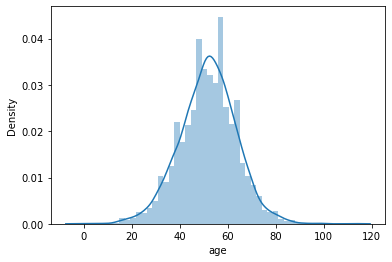

In [4177]:
sns.distplot(df_merged['age'])

In [4178]:
# from numpy import exp
# from numpy.random import randn
# from sklearn.preprocessing import PowerTransformer
# from matplotlib import pyplot

# # generate gaussian data sample
# data = df_merged['age'].values.reshape(-1, 1)

# # histogram of the raw data with a skew
# pyplot.hist(data, bins=25)

# # reshape data to have rows and columns
# data = data.reshape(-1,1)

# # power transform the raw data
# power = PowerTransformer(method='box-cox', standardize=True) 
# data_trans = power.fit_transform(data)
 
# # histogram of the transformed data
# pyplot.hist(data_trans, bins=25) 

c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00, 4.000e+00, 6.000e+00, 9.000e+00, 3.600e+01, 1.570e+02,
        5.590e+02, 1.385e+03, 1.444e+03, 5.060e+02, 2.730e+02, 4.150e+02,
        4.690e+02]),
 array([-10.29353507,  -9.79483454,  -9.29613402,  -8.7974335 ,
         -8.29873297,  -7.80003245,  -7.30133193,  -6.8026314 ,
         -6.30393088,  -5.80523036,  -5.30652984,  -4.80782931,
         -4.30912879,  -3.81042827,  -3.31172774,  -2.81302722,
         -2.3143267 ,  -1.81562617,  -1.31692565,  -0.81822513,
         -0.3195246 ,   0.17917592,   0.67787644,   1.17657696,
          1.67527749,   2.17397801]),
 <a list of 25 Patch objects>)

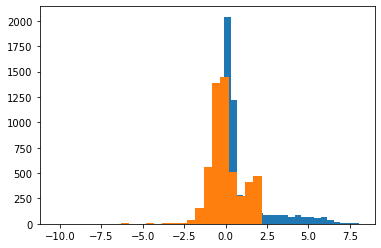

In [4179]:
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

# generate gaussian data sample
data = df_merged['kurtosis_glucose'].values.reshape(-1, 1)

# # add a skew to the data distribution
# data = exp(data)

# histogram of the raw data with a skew
pyplot.hist(data, bins=25)

# reshape data to have rows and columns
# data = data.reshape((len(data),1))

# power transform the raw data
power = PowerTransformer(method='yeo-johnson', standardize=True) 
data_trans = power.fit_transform(data)
 
# histogram of the transformed data
pyplot.hist(data_trans, bins=25) 

c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


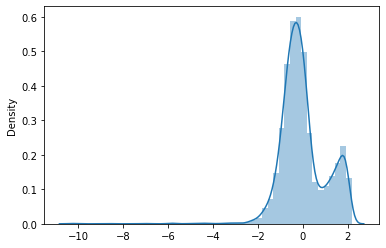

In [4180]:
sns.distplot(data_trans)

In [4181]:
# def remove_outliers(data_frame, column, koeficient):
#     seed(1)
#     data = data_frame[column]

#     # calculate summary statistics
#     data_mean, data_std = mean(data), std(data)
#     print('len=', len(data), 'mean=', data_mean, 'std=', data_std)

#     # define outliers
#     cut_off = data_std * koeficient
#     lower, upper = data_mean - cut_off, data_mean + cut_off 
#     print('cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

#     # identify outliers
#     outliers = [x for x in data if x < lower or x > upper] 
#     print('Identified outliers: %d' % len(outliers))

#     # remove outliers
#     data = [x for x in data if x >= lower and x <= upper]
# #     print('Non-outlier observations: %d' % len(outliers_removed))
#     print('Non-outlier observations: %d' % len(data))

#     sns.distplot(data)
# #     sns.distplot(outliers_removed)
#     sns.distplot(data)
    
# #     data_frame = data_frame.drop(outliers.index)
#     return data
    
# #     return outliers_removed

In [4182]:
# def remove_outliers(data_frame, column, koeficient):
#     seed(1)
#     data = data_frame[column]

#     # calculate summary statistics
#     data_mean, data_std = mean(data), std(data)
#     print('len=', len(data), 'mean=', data_mean, 'std=', data_std)

#     # define outliers
#     cut_off = data_std * koeficient
#     lower, upper = data_mean - cut_off, data_mean + cut_off 
#     print('cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

#     # identify outliers
# #     outliers = [x for x in data if x < lower or x > upper] 
#     outliers = data[(data > upper) | (data < lower)]
#     print('Identified outliers: %d' % len(outliers))

#     # remove outliers
#     outliers_removed = [x for x in data if x >= lower and x <= upper]
#     print('Non-outlier observations: %d' % len(outliers_removed))

#     sns.distplot(data)
#     sns.distplot(outliers_removed)
    
#     data_frame = data_frame.drop(outliers.index)
#     return data_frame
    
# #     return outliers_removed

In [4183]:
# def remove_outliers(data_frame, column):
#     a = data_frame[column]
#     lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
#     upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
#     outliers = a[(a > upper) | (a < lower)]
#     data_frame = data_frame.drop(outliers.index)
#     return data_frame

In [4184]:
# def remove_outliers(data_frame, column, koeficient):
#     seed(1)
#     data = data_frame[column]
#     sns.distplot(data)

#     # calculate interquartile range
#     q25, q75 = percentile(data, 20), percentile(data, 80)
#     iqr = q75 - q25
#     print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr)) 

#     # calculate the outlier cutoff
#     cut_off = iqr * 1.5
#     lower, upper = q25 - cut_off, q75 + cut_off
#     print('cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

#     # identify outliers
#     outliers = data[(data > upper) | (data < lower)]
#     print('Identified outliers: %d' % len(outliers))

#     # remove outliers
#     outliers_removed = [x for x in data if x >= lower and x <= upper] 
#     print('Non-outlier observations: %d' % len(outliers_removed))

#     sns.distplot(outliers_removed)
    
#     data_frame = data_frame.drop(outliers.index)
#     return data_frame

In [4185]:
def remove_outliers(data_frame, column, koeficient):
    seed(1)
    data = data_frame[column]
    sns.distplot(data)

    # calculate interquartile range
    q25, q75 = percentile(data, 5), percentile(data, 95)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr)) 

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

    # identify outliers
    outliers = data[(data > upper) | (data < lower)]
    print('Identified outliers: %d' % len(outliers))

    # remove outliers
    outliers_removed = [x for x in data if x >= lower and x <= upper] 
    print('Non-outlier observations: %d' % len(outliers_removed))

    sns.distplot(outliers_removed)
    
    data_frame = data_frame.drop(outliers.index)
    return data_frame

c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


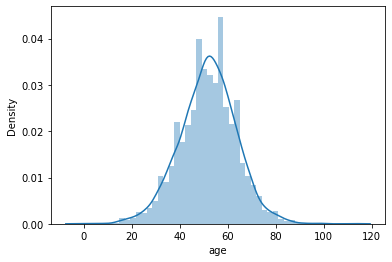

In [4186]:
sns.distplot(df_merged['age'])

c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Percentiles: 25th=32.000, 75th=70.000, IQR=38.000
cutoff= 57.0 lower= -25.0 upper= 127.0
Identified outliers: 0
Non-outlier observations: 5294


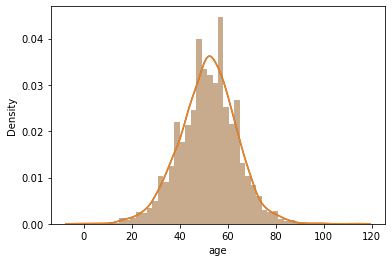

In [4187]:
df_merged = remove_outliers(df_merged, "age", 4)

In [4188]:
print(df_merged['age'].min())

-1


 20  mean_glucose      5279 non-null   float64
 21  std_glucose       4751 non-null   float64
 22  kurtosis_glucose  5279 non-null   float64
 23  skewness_glucose  5279 non-null   float64
 24  mean_oxygen       5279 non-null   float64
 25  std_oxygen        5279 non-null   float64
 26  kurtosis_oxygen   5279 non-null   float64
 27  skewness_oxygen   5279 non-null   float64

Percentiles: 25th=nan, 75th=nan, IQR=nan
cutoff= nan lower= nan upper= nan
Identified outliers: 0
Non-outlier observations: 0


c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\matto\appdata\local\programs\python\python38\lib\sit

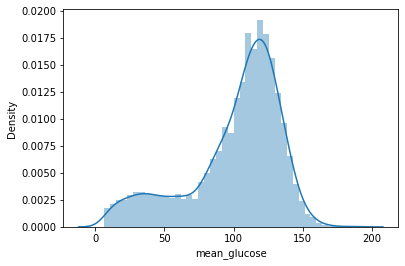

In [4189]:
df_merged = remove_outliers(df_merged,"mean_glucose", 2)

c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Percentiles: 25th=31.508, 75th=55.823, IQR=24.315
cutoff= 36.47217334349999 lower= -4.964380897499986 upper= 92.29474801849999
Identified outliers: 0
Non-outlier observations: 4815


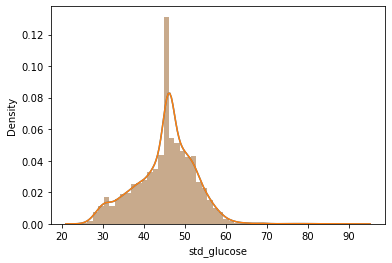

In [4212]:
df_merged = remove_outliers(df_merged,"std_glucose", 4)

Percentiles: 25th=nan, 75th=nan, IQR=nan
cutoff= nan lower= nan upper= nan
Identified outliers: 0
Non-outlier observations: 0


c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


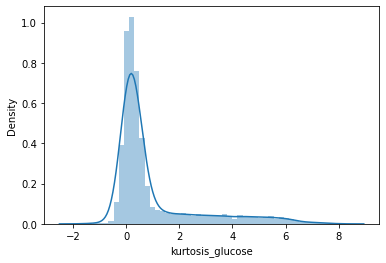

In [4191]:
df_merged = remove_outliers(df_merged,"kurtosis_glucose", 3)

Percentiles: 25th=nan, 75th=nan, IQR=nan
cutoff= nan lower= nan upper= nan
Identified outliers: 0
Non-outlier observations: 0


c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


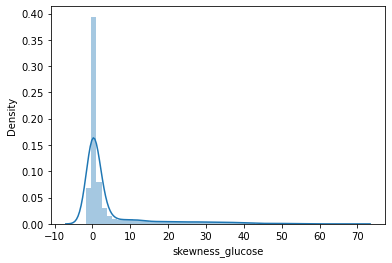

In [4192]:
df_merged = remove_outliers(df_merged,"skewness_glucose", 3)

In [4193]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5288 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4194]:
df_merged['std_glucose'].isnull().sum()

543

In [4195]:
def get_mode(data_frame, column):
    data = data_frame[column].values.reshape(-1, 1)
    imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    data_frame[column] = imp.fit_transform(data)
    return data_frame

In [4196]:
def get_median(data_frame, column):
    median = data_frame[column].median()
    data_frame[column].fillna(median, inplace = True)
    return data_frame

In [4197]:
def get_mean(data_frame, column):
    mean = data_frame[column].mean()
    data_frame[column].fillna(mean, inplace = True)
    return data_frame

In [4198]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              4912 non-null   object 
 6   marital-status    5280 non-null   object 
 7   occupation        5276 non-null   object 
 8   pregnant          5288 non-null   object 
 9   education-num     5275 non-null   float64
 10  relationship      5271 non-null   object 
 11  capital-gain      5274 non-null   float64
 12  education         5278 non-null   object 
 13  fnlwgt            5282 non-null   float64
 14  class             5278 non-null   float64
 15  income            5273 non-null   object 
 16  native-country    5281 non-null   object 


In [4199]:
 def fill_median(data_frame):
    data_frame = get_median(data_frame, "mean_glucose")
    data_frame = get_median(data_frame, "std_glucose")
    data_frame = get_median(data_frame, "kurtosis_glucose")
    data_frame = get_median(data_frame, "skewness_glucose")
    data_frame = get_median(data_frame, "mean_oxygen")
    data_frame = get_median(data_frame, "std_oxygen")
    data_frame = get_median(data_frame, "kurtosis_oxygen")
    data_frame = get_median(data_frame, "skewness_oxygen")
    
    data_frame = get_median(data_frame, "education-num")
    data_frame = get_median(data_frame, "capital-gain")
    data_frame = get_median(data_frame, "fnlwgt")
    data_frame = get_median(data_frame, "hours-per-week")
    data_frame = get_median(data_frame, "capital-loss")
    
    return data_frame

In [4200]:
 def fill_mode(data_frame):
    data_frame = get_mode(data_frame, "race")
    data_frame = get_mode(data_frame, "marital-status")
    data_frame = get_mode(data_frame, "occupation")
    data_frame = get_mode(data_frame, "pregnant")
    data_frame = get_mode(data_frame, "relationship")
    data_frame = get_mode(data_frame, "education")
    data_frame = get_mode(data_frame, "income")
    data_frame = get_mode(data_frame, "native-country")
    data_frame = get_mode(data_frame, "workclass")
    
    data_frame = get_mode(data_frame, "class")
    
    return data_frame

In [4201]:
df_merged = fill_median(df_merged)

In [4202]:
df_merged = fill_mode(df_merged)

In [4203]:
df_merged.to_csv(r'data/export.csv')

In [4204]:
df_merged['capital-loss'].unique()

array([   0., 1977., 1974., 1887., 1573., 2002., 1594., 2559., 1902.,
       1380., 1590., 1762., 2001., 1408., 1876., 1848., 1504., 2206.,
       1579., 1340., 1539., 1564., 1721., 2824., 1485., 1672., 1602.,
        419., 2415., 1825., 1719., 1740., 1741., 1411., 2051., 1617.,
       1669., 2377., 2179., 1092., 1980.,  653., 2246., 1138.,  155.,
        323., 2205., 2547.,  880., 2129., 1651.,  625., 2174., 2258.,
       2352., 1628.])

In [4205]:
df_merged = get_mode(df_merged, "race")

In [4206]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5294 entries, 0 to 5293
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5294 non-null   object 
 1   address           5294 non-null   object 
 2   age               5294 non-null   int64  
 3   sex               5294 non-null   object 
 4   date_of_birth     5294 non-null   object 
 5   race              5294 non-null   object 
 6   marital-status    5294 non-null   object 
 7   occupation        5294 non-null   object 
 8   pregnant          5294 non-null   object 
 9   education-num     5294 non-null   float64
 10  relationship      5294 non-null   object 
 11  capital-gain      5294 non-null   float64
 12  education         5294 non-null   object 
 13  fnlwgt            5294 non-null   float64
 14  class             5294 non-null   float64
 15  income            5294 non-null   object 
 16  native-country    5294 non-null   object 


In [4207]:
df_merged.describe()

,age,education-num,capital-gain,fnlwgt,class,hours-per-week,capital-loss,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
count,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000,5294.000000
mean,51.860597,10.060446,1101.170193,189145.556101,0.256895,40.247828,75.328674,101.129522,48.477093,0.961067,4.280862,18.798533,31.490378,7.364672,90.668134
std,11.831386,2.500884,7733.755058,102401.463303,0.436962,12.472156,369.887343,33.706349,1355.453305,1.616226,9.732088,34.980444,22.531720,4.824470,108.029107
min,-1.000000,1.000000,0.000000,12285.000000,0.000000,1.000000,0.000000,6.187500,-8305.388133,-1.641515,-1.791886,0.213211,7.370432,-2.597872,-1.976976
25%,44.000000,9.000000,0.000000,119042.000000,0.000000,40.000000,0.000000,87.056641,40.257344,0.067056,-0.122869,2.063963,15.021076,3.541348,11.707000
50%,52.000000,10.000000,0.000000,178339.500000,0.000000,40.000000,0.000000,110.507812,46.001844,0.309383,0.385674,3.321070,20.771313,7.644468,66.417793
75%,60.000000,12.000000,0.000000,235851.500000,1.000000,45.000000,0.000000,124.371094,50.291593,0.828019,2.208651,13.144022,43.946307,10.269364,127.250625
max,113.000000,16.000000,99999.000000,795830.000000,1.000000,99.000000,2824.000000,189.734375,7678.445784,8.069522,68.101622,217.371238,110.642211,34.539844,1191.000837
